<a href="https://colab.research.google.com/github/lavanyashukla/CycleGAN/blob/master/SpaceInvaders_Baseline_Model_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Invaders



In [0]:
!pip install wandb -qq
!pip install gym pyvirtualdisplay -qq
!apt-get install -y xvfb python-opengl ffmpeg -qq
!pip install xdpyinfo -qq

!apt-get update -qq
!apt-get install cmake -qq
!pip install --upgrade setuptools -qq
!pip install ez_setup -qq

ERROR: Could not find a version that satisfies the requirement xdpyinfo (from versions: none)
ERROR: No matching distribution found for xdpyinfo


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import glob
import io
import base64
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# import wandb
import wandb

## Preprocessing - crop images, convert them to 1D black and white image tensors

- Image dimensions - (210, 160, 3)
- Output dimensions - (88, 80, 1)


In [0]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Crop and resize
    img = obs[25:201:2, ::2]

    # Convert to greyscale
    img = img.mean(axis=2)

    # Improve contrast
    img[img==color] = 0

    # Normalzie image
    img = (img - 128) / 128 - 1

    # Reshape to 80*80*1
    img = img.reshape(88,80)

    return img 

## Initialize gym environment and explore game screens


In [0]:
env = gym.make("SpaceInvaders-v0")
print("Actions available(%d): %r"%(env.action_space.n, env.env.get_action_meanings()))

Actions available(6): ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


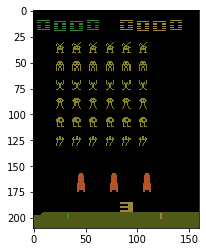

In [0]:
observation = env.reset()
# Game Screen
for i in range(11):
  if i > 9:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

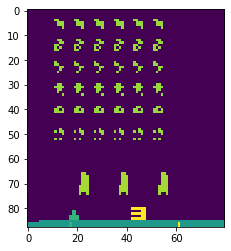

In [0]:
# Preprocessed Game Screen
obs_preprocessed = preprocess_frame(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()

## Play Game

### Play a random game, log reward and gameplay video in wandb

In [0]:
# initialize a new wandb run
wandb.init(project="qualcomm")

# define hyperparameters
wandb.config.episodes = 100
wandb.config.batch_size = 48
wandb.config.learning_rate = 0.001
input_shape = (None, 88, 80, 1)

# record gameplay video
display = Display(visible=0, size=(1400, 900))
display.start()

# reward across episodes
cumulative_reward = 0

# run for 100 episodes
for i in range(wandb.config.episodes):
  # Set reward received in this episode = 0 at the start of the episode
  episodic_reward = 0

  # record a video of the game using wrapper
  env = gym.wrappers.Monitor(env, './video', force=True)
  
  episode = i+1
  print("Episode: %d"%(episode))
  
  # play a random game
  state = env.reset()
  done = False
  while not done:
    # take random action
    # ****TODO: replace this with model prediction****
    action = env.action_space.sample()

    # perform the action and fetch next state, reward
    state, reward, done, _ = env.step(action)

    episodic_reward += reward
  
  # log total reward received in this episode to wandb
  wandb.log({'episodic_reward': episodic_reward})

  # add reward from this episode to cumulative_reward
  cumulative_reward += episodic_reward

  # calculate the cumulative_avg_reward
  # this is the metric your models will be evaluated on
  cumulative_avg_reward = cumulative_reward/episode

  # log cumulative_avg_reward over episodes to wandb
  wandb.log({'cumulative_avg_reward': cumulative_avg_reward})

  # your models will be evaluated on 100-episode average reward
  # therefore, we stop logging after 100 episodes
  if (episode > 100):
    break

  record_video = False
  env.close() 

  # render gameplay video
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    print(len(mp4list))
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)

    # log gameplay video in wandb
    wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

    # display gameplay video
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))